# Day 3 线性回归、决策树、交叉验证、网格搜索；
`LinearRegression`, `XHBoost`, `cross_val_score`, `GridSearchCV`；任务：`California Housing`，目标 R² >0.7。

In [10]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("camnugent/california-housing-prices")

print("Path to dataset files:", path)

Path to dataset files: /home/dove/.cache/kagglehub/datasets/camnugent/california-housing-prices/versions/1


数据集已被移动至data目录。  

In [ ]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PowerTransformer

In [55]:
data = pd.read_csv('../data/California/housing.csv')
x = data.drop('median_house_value', axis=1)
y = data['median_house_value']
x.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
ocean_proximity         0
dtype: int64

缺失值特征：total_bedrooms（数）

In [56]:
categorical_columns = x.select_dtypes(include=['object', 'category']).columns

for col in categorical_columns:
    print(f"--- Column: {col} ---")
    # 查看该列所有 unique 值及其数量 (最多显示前面几个)
    print(x[col].value_counts(dropna=False).head(10)) # dropna=False 非常重要！它会包含 np.nan 的计数
    print("\n")

--- Column: ocean_proximity ---
ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64




In [57]:
x.replace('',np.nan,inplace=True)
x.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
ocean_proximity         0
dtype: int64

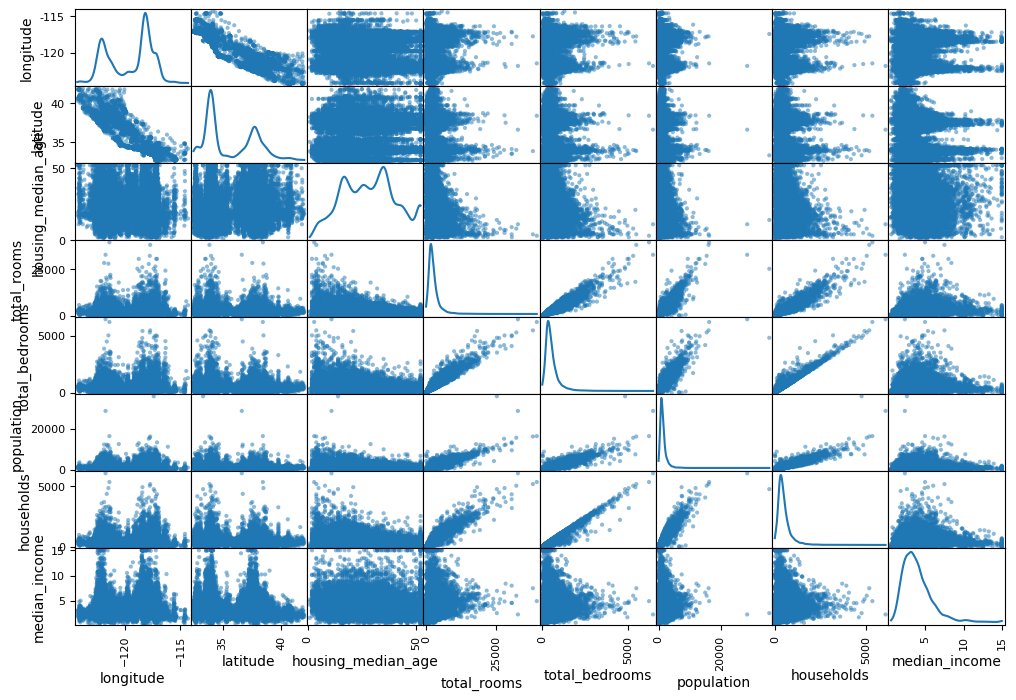

In [31]:
x_num=x.drop('ocean_proximity',axis=1)
pd.plotting.scatter_matrix(x_num,figsize=(12,8),diagonal='kde');

- 数据没有明显异常值，分布接近正态： StandardScaler 是个不错的起点。
- 数据有明显异常值： 优先考虑 RobustScaler。
- 数据需要在固定范围内（如 [0,1]）： 使用 MinMaxScaler，但要小心异常值的影响。
- 数据是稀疏的： 考虑 MaxAbsScaler 或 StandardScaler(with_mean=False)。
- 数据有明显偏态，希望更接近正态： 尝试 PowerTransformer 或 QuantileTransformer(output_distribution='normal')。
- 关注样本间相似度（如余弦相似度）： 使用 Normalizer (行操作)。

正态分布的scaler会扭曲数据分布，尽量只在模型具有正态假设时使用，这一把包括传统的统计模型，线性回归是其中之一

In [58]:
# 修正train_test_split的参数顺序
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=41)

In [59]:
x_train.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        173
population              0
households              0
median_income           0
ocean_proximity         0
dtype: int64

In [84]:
num=['longitude','latitude','housing_median_age','total_rooms','total_bedrooms','population','households','median_income']
cat=['ocean_proximity']

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('power_transformer', PowerTransformer(method='yeo-johnson')), 
    ('scaler', StandardScaler())
])
cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num),
        ('cat', cat_transformer, cat)
    ]
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [85]:
x_train_transformed = preprocessor.fit_transform(x_train)
x_train_transformed = pd.DataFrame(x_train_transformed, columns=preprocessor.get_feature_names_out())
x_test_transformed = preprocessor.transform(x_test)
x_test_transformed = pd.DataFrame(x_test_transformed, columns=preprocessor.get_feature_names_out()) #训练集和测试机列名要一致
x_train_transformed.isna().sum()

num__longitude                     0
num__latitude                      0
num__housing_median_age            0
num__total_rooms                   0
num__total_bedrooms                0
num__population                    0
num__households                    0
num__median_income                 0
cat__ocean_proximity_<1H OCEAN     0
cat__ocean_proximity_INLAND        0
cat__ocean_proximity_ISLAND        0
cat__ocean_proximity_NEAR BAY      0
cat__ocean_proximity_NEAR OCEAN    0
dtype: int64

In [86]:
reg = LinearRegression()
reg.fit(x_train_transformed, y_train)
x_pred = reg.predict(x_test_transformed)

也可直接使用model pipeline, 不需要担心特征名称的问题，因为整个过程都在 Pipeline 中处理

In [87]:
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [73]:
model.score(x_test, y_test)

0.6022768946186297

**cross_val_score** 把数据集分成几份，然后循环进行：用一部分训练，用另一部分验证（不用手动划分数据集了！），得到一个分数。重复这个过程，最终返回所有验证分数的列表。

In [88]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, x, y, cv=5, scoring='r2')
print(f"交叉验证 R² scores: {scores}")
print(f"平均 R² score: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")

交叉验证 R² scores: [0.42038549 0.48783847 0.60402702 0.39961897 0.61924881]
平均 R² score: 0.506 (+/- 0.182)


似乎不太理想。改进思路有：  
- 特征工程：检查并清理数据，尝试添加、组合或删除一些特征；  
- 模型复杂度：如果线性回归效果有限，可以尝试更复杂的模型，比如决策树、随机森林或者梯度提升（如 XGBoost）。  
- 超参数调优：利用网格搜索（GridSearchCV）或随机搜索寻找更合适的模型参数。  
- 处理异常值和多重共线性：考虑去除或调整异常值，以及关注特征间的相关性，避免多重共线性影响。 
- 数据标准化/归一化：尝试不同的 scaler（如 RobustScaler 或 MinMaxScaler），看哪种对模型更友好。  

线性回归复杂度有限，为了暂时避免繁琐的特征工程，我们使用其他模型，比如树模型。以下使用**XGBoost**。

**XGBoost** 是一个基于梯度提升的框架，通过引入正则化、使用二阶泰勒展开来优化目标函数、设计包含正则化的分裂增益公式、以及各种工程优化（并行化、缺失值处理、采样技术），使其成为一个高效、准确且不易过拟合的强大模型。它在一步步地构建简单树的过程中，不断地拟合当前模型的“残差”信息（由损失函数的一阶和二阶梯度表示），并用正则化来约束树的生长，最终得到一个由大量弱模型组成的强大集成模型。

In [ ]:
from xgboost import XGBRegressor

num = ['longitude','latitude','housing_median_age','total_rooms','total_bedrooms','population','households','median_income']
cat = ['ocean_proximity']

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('power_transformer', PowerTransformer(method='yeo-johnson')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num),
        ('cat', cat_transformer, cat)
    ]
)
#预处理与前面完全一致

model_XGB = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42, 
                               objective='reg:squarederror',#损失函数
                               n_estimators=100, #树的数量（迭代次数）
                               learning_rate=0.1,
                               max_depth=3,
                               n_jobs=-1))
])

XGB参数：
- objective:分类：binary:logistic, multi:softprob, multi:softmax；回归：reg:squarederror, reg:logistic, reg:absoluteerror 等  

In [83]:
scores = cross_val_score(model_XGB, x, y, cv=5, scoring='r2')
print(f"交叉验证 R² scores: {scores}")
print(f"平均 R² score: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")

交叉验证 R² scores: [0.48649334 0.60834148 0.69899649 0.44970049 0.72485669]
平均 R² score: 0.594 (+/- 0.220)


很棒，提升了10%！

使用**GridSearchCV/RandomizedSearchCV**来寻找最优的超参数组合。

In [89]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform, randint, loguniform

使用方法：
1. 创建超参数字典
2. 创建SearchCV对象
3. 调用fit方法
属性：
1. best_params_：返回最佳参数
2. best_score_：返回最佳得分
3. best_estimator_：返回最佳模型


In [92]:
# 定义要搜索的参数空间 (以 RandomizedSearch 为例)
# 标签名__超参数名，格式不能错
param_distributions = {
    'regressor__n_estimators': randint(50, 500), 
    'regressor__learning_rate': loguniform(0.01, 0.2), # 学习率在 0.01 到 0.2 对数均匀采样
    'regressor__max_depth': randint(3, 10), 
    'regressor__subsample': uniform(0.6, 0.4), # 行采样比例在 0.6 到 1.0 之间均匀采样 (0.6 + 0.4)
    'regressor__colsample_bytree': uniform(0.6, 0.4), 
    'regressor__gamma': uniform(0, 0.2), # 正则化参数 gamma 在 0 到 0.2 之间均匀采样
    'regressor__reg_alpha': loguniform(0.001, 1), # L1 正则化
    'regressor__reg_lambda': loguniform(0.001, 1) # L2 正则化
}

random_search_pipe = RandomizedSearchCV(
    estimator=model_XGB,
    param_distributions=param_distributions,
    n_iter=100, # 尝试 100 个随机组合
    cv=5, # 5 折交叉验证
    scoring='r2', 
    random_state=42,
    n_jobs=-1
)

SearchCV会在最优参数在整个训练集上再训练一次，并把最终模型保存。

**GridSearchCV和RandomizedSearchCV的区别：**   
GridSearchCV: 保证在设定的网格内找到最优解，但当网格很大时计算量呈指数级增长。适合超参数少，或者想在小范围精调。   
RandomizedSearchCV: 在设定的次数内从分布中随机采样，计算量固定，在大搜索空间下效率高，更容易快速找到一个不错的解。适合超参数多，或者想快速探索大范围。

In [93]:
# 在训练集上进行随机搜索
random_search_pipe.fit(x_train, y_train)

# 在测试集上评估最佳模型
final_score = random_search_pipe.score(x_test, y_test)
print(f"最终测试集得分: {final_score:.3f}")

最终测试集得分: 0.847


WoW！太酷啦！

XGBoost的RandomSearchCV实现在